In [ ]:
from pyhive import presto
from sqlalchemy import create_engine
from string import Template

class DataHandler:

    def __init__(self, params):
        self.params = params
        self.market = params['market']
        self.cnxn = self.connect_to_presto()
        self.engine = create_engine(f"presto://presto-{self.market}.taxibeat.com:8080/")

    def connect_to_presto(self):
        """
        Function to initialize connection with Presto database
        """
        try:
            cnxn = presto.connect(host=f"presto-{self.market}.taxibeat.com", port=8080)
        except presto.DatabaseError as err:
            print(f"Error: Could not make connection to Presto DB: {err}")
        return cnxn

    def execute_query(self, query):
        df = pd.read_sql_query(query, self.cnxn)
        return df
    
    def read_query(self, path):
        with open(path, "r") as f:
            query = f.read()
        return query
    
    def transform_query(self, query):
        query = Template(query)
        transformed_query = query.substitute(self.params)
        return transformed_query

    def drop_table(self, table_name):
        query = f"DROP TABLE IF EXISTS {table_name}"
        pd.read_sql_query(query, self.cnxn)

    def store_data(self, table_name, df, mode='replace'):
        df.to_sql(
            name=table_name,
            con=self.engine,
            if_exists=mode,
            index=False,
            chunksize=10000,
            method='multi'
        )
        
        
params={"country": "colombia",
        "market": "co"}

d = DataHandler(params)

df = d.execute_query(""" select * from
co.dna.underestimated_rides_raw_level_data limit 2000000
""")

In [1]:
def find_category_mappings(df, variable):
    return {k: i for i, k in enumerate(df[variable].unique(), 0)}

def integer_encode(df, variable, ordinal_mapping):
    df[variable] = df[variable].map(ordinal_mapping)
    
def calculate_top_categories(df, variable, n=10):
    return [x for x in df[variable].value_counts().sort_values(ascending=False).head(n).index]

def one_hot_encode(df, variable, top_labels):
    for label in top_labels:
        df[variable + '_' + label] = np.where(df[variable] == label, 1, 0)
        
def frequency_encoding(df,variable):
    count_map = df[variable].value_counts().to_dict()
    df[variable + '_' + 'freq_encoding'] = df[variable].map(count_map) / len(df)
    
def find_freq_labels(data, variable, upper_tolerance, lower_tolerance):
    
    temp = data.groupby([variable])[variable].count() / len(data)
    
    high_freq = [x for x in temp.loc[temp>upper_tolerance].index.values]
    med_freq = [x for x in temp.loc[(temp>lower_tolerance) & (temp<upper_tolerance)].index.values]
    rare_freq = [x for x in temp.loc[temp<lower_tolerance].index.values]
    
    return high_freq, med_freq, rare_freq

def discretize(data, var, num_of_bins):
    disc, intervals = pd.qcut(
    data[var], num_of_bins, labels=['Q'+str(i) for i in range(1,num_of_bins+1)], 
    retbins=True, precision=3, duplicates='raise')

    data[var+'_discretized'] = disc
    
def remove_outlier(df, col_name, multiplier=1.5):
    q1 = df[col_name].quantile(0.05)
    q3 = df[col_name].quantile(0.95)
    iqr = q3 - q1 #Interquartile Range
    low_bound  = q1 - multiplier * iqr
    high_bound = q3 + multiplier * iqr
    df_out = df.loc[(df[col_name] > low_bound) & (df[col_name] < high_bound)]
    
    return df_out

def stratify_data(df_data, stratify_column_name, stratify_values, stratify_proportions, random_state=None):
    """Stratifies data according to the values and proportions passed in
    Args:
        df_data (DataFrame): source data
        stratify_column_name (str): The name of the single column in the dataframe that holds the data values that will be used           to stratify the data
        stratify_values (list of str): A list of all of the potential values for stratifying e.g. "Train, Validate", "Test"
        stratify_proportions (list of float): A list of numbers representing the desired propotions for stratifying e.g. 0.4,             0.4, 0.2. The list values must add up to 1 and must match the number of values in stratify_values
        random_state (int, optional): sets the random_state. Defaults to None.
    Returns:
        DataFrame: a new dataframe based on df_data that has the new proportions represnting the desired strategy for stratifying
    """
    df_stratified = pd.DataFrame(columns = df_data.columns) # Create an empty DataFrame with column names matching df_data
    pos = -1
    for i in range(len(stratify_values)): # iterate over the stratify values (e.g. Train, Validate, Test)
        pos += 1
        if pos == len(stratify_values) - 1:
            ratio_len = len(df_data) - len(df_stratified) # if this is the final iteration make sure we calculate the number of values for the last set such that the return data has the same number of rows as the source data
        else:
            ratio_len = int(len(df_data) * stratify_proportions[i]) # Calculate the number of rows to match the desired proportion
        df_filtered = df_data[df_data[stratify_column_name] ==stratify_values[i]] # Filter the source data based on the currently selected stratify value
        df_temp = df_filtered.sample(replace=True, n=ratio_len, random_state=random_state) # Sample the filtered data using the calculated ratio
        df_stratified = pd.concat([df_stratified, df_temp]) # Add the sampled / stratified datasets together to produce the final result
    
    return df_stratified # Return the stratified, re-sampled data

def equal_sampling (data, col, randomstate):
    k = data[col].value_counts().min()
    df = data.groupby(col).apply(lambda x: x.sample(k,random_state=randomstate)) 
    df.index = df.index.droplevel(0)
    
    return df

In [46]:
import pandas as pd
import numpy as np
import datetime as dt
import timedelta

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

import warnings
warnings.filterwarnings("ignore")

In [47]:
#df.to_csv('distanceestimation_co_2.csv')
df = pd.read_csv('distanceestimation_co_2.csv').sort_values('created_local')
df.distance_actual = df.distance_actual / 1000
del df['Unnamed: 0']

In [48]:
df = df[(df.distance_est>1) & (df.distance_est<5)] 

In [49]:
# Basic Transformations - Not used as Features
df['timestamp'] = pd.to_datetime(df.created_local)
df['date'] = pd.to_datetime(df.created_local).dt.date
df['time'] = pd.to_datetime(df.created_local).dt.time

# Day and Time Features
df['hour'] = pd.to_datetime(df.created_local).dt.hour
df['minute'] = pd.to_datetime(df.created_local).dt.minute
df['weekday'] = pd.to_datetime(df.date).dt.weekday

# Basic Definition of error distance&duration-wise
df['dur_per_dist_est'] = df.estimate_duration/df.distance_est # Known value at the moment 
df['dur_per_dist_act'] = df.actual_duration_s/df.distance_actual # Known value at the end of the ride 

# Connecting Duration and Distance
df['dur_error'] = df.actual_duration_s/df.estimate_duration - 1
df['dist_error'] = df.distance_actual/df.distance_est - 1

# Definition of error based on the Duration per Distance (Km) ratio - Negative values imply underestimation
df['ratio_error'] = df.dur_per_dist_est/df.dur_per_dist_act - 1

In [50]:
df.columns

Index(['created_local', 'id_city', 'id_ride', 'id_driver', 'actual_duration_s',
       'estimate_duration', 'distance_actual', 'distance_est', 'base_fare',
       'service', 'surge_level', 'from_zone', 'to_zone', 'pickup_eta',
       'estimated_eta', 'timestamp', 'date', 'time', 'hour', 'minute',
       'weekday', 'dur_per_dist_est', 'dur_per_dist_act', 'dur_error',
       'dist_error', 'ratio_error'],
      dtype='object')

In [51]:
# Create the categorical variable
#df['OnD'] = df.from_zone.astype('str') + '_' + df.to_zone.astype('str')
#frequency_encoding(df,'OnD')
#discretize(df,'OnD_freq_encoding',20)

df['origin'] = df.from_zone.astype('str')
df['destination'] = df.to_zone.astype('str')
frequency_encoding(df,'origin')
frequency_encoding(df,'destination')

#frequency_encoding(df,'id_driver')
#prone = df[df.target==1].groupby('id_driver')['id_city'].count().sort_values(ascending=False).head(30).index
#df['prone'] = np.where(df.id_driver.isin(list(prone)),1,0)

one_hot_encode(df,'service',df.service.unique())
one_hot_encode(df,'id_city',df.id_city.unique().astype('str'))
#one_hot_encode(df,'hour',df.hour.unique().astype('str'))

#top20_from_zones = calculate_top_categories(df,'from_zone',10)
#df['top_10_from_zone'] = np.where(df.from_zone.isin(top20_from_zones),1,0)
#top20_to_zones = calculate_top_categories(df,'to_zone',10)
#df['top_10_to_zone'] = np.where(df.to_zone.isin(top20_to_zones),1,0)

In [52]:
df

created_local  id_city    id_ride  id_driver  \
1384156  2022-03-01 00:00:35.000        1  154094919    1641380   
307819   2022-03-01 00:00:41.000        2  154094921    1636890   
1777656  2022-03-01 00:01:44.000        1  154094932       3873   
648265   2022-03-01 00:01:47.000        1  154094934    1617765   
1424070  2022-03-01 00:02:33.000        1  154094946    1608904   
...                          ...      ...        ...        ...   
1722993  2022-06-30 18:55:48.000        1  163475188    1220700   
1680954  2022-06-30 18:55:52.000        1  163475193     934781   
1743205  2022-06-30 18:57:51.000        4  163475336     381909   
1929241  2022-06-30 18:58:12.000        2  163475355    1291125   
1714955  2022-06-30 18:58:59.000        3  163475399     463504   

         actual_duration_s  estimate_duration  distance_actual  distance_est  \
1384156                274                272         1.480884          1.87   
307819                 600                428         3.764977          3.87   
1777656                283                291         2.574966          2.63   
648265                 538                478         3.807332          3.76   
1424070                380                364         2.329844          2.23   
...                    ...                ...              ...           ...   
1722993                539                448         1.879935          1.85   
1680954                592                457         1.451683          1.55   
1743205                555                440         3.106130          2.17   
1929241               1072                856         4.257802          4.89   
1714955               2356                784              NaN          4.32   

         base_fare service  ...  service_Lite service_Pronto service_Envío  \
1384156     4400.0    Beat  ...             0              0             0   
307819      6800.0    Lite  ...             1              0             0   
1777656     4600.0    Beat  ...             0              0             0   
648265      5700.0    Beat  ...             0              0             0   
1424070     4500.0    Beat  ...             0              0             0   
...            ...     ...  ...           ...            ...           ...   
1722993     5400.0    Beat  ...             0              0             0   
1680954     5100.0    Beat  ...             0              0             0   
1743205     5600.0    Beat  ...             0              0             0   
1929241     9600.0    Beat  ...             0              0             0   
1714955     7800.0    Beat  ...             0              0             0   

         service_Plus  service_Zero id_city_1 id_city_2 id_city_6  id_city_4  \
1384156             0             0         0         0         0          0   
307819              0             0         0         0         0          0   
1777656             0             0         0         0         0          0   
648265              0             0         0         0         0          0   
1424070             0             0         0         0         0          0   
...               ...           ...       ...       ...       ...        ...   
1722993             0             0         0         0         0          0   
1680954             0             0         0         0         0          0   
1743205             0             0         0         0         0          0   
1929241             0             0         0         0         0          0   
1714955             0             0         0         0         0          0   

         id_city_3  
1384156          0  
307819           0  
1777656          0  
648265           0  
1424070          0  
...            ...  
1722993          0  
1680954          0  
1743205          0  
1929241          0  
1714955          0  

[1019642 rows x 41 columns]

In [53]:
#df['timestamp_shift'] = df['timestamp'].shift(-1)
#df['time_delta'] = (df.timestamp_shift - df.timestamp) / pd.Timedelta(minutes=1)
#del df['timestamp_shift']

In [54]:
# Target Variable on either Duration or Distance

#df['under_est_dur'] = np.where(df.dur_error > 0.08, 1, 0)
#df['under_est_dist'] = np.where(df.dist_error > 0.3, 1, 0)

# Target Variable on Duration per Km ratio 
df['target'] = np.where(df.ratio_error < -0.06, 1, 0)

### Get the last target values for drivers OnDs and Destinations

In [55]:
## For the Drivers

#last_drv_target = df.shift(-1).sort_values(by='created_local').drop_duplicates('id_driver', keep='last')\
#                   [['id_driver','target']]
#df = df.merge(last_drv_target.set_index('id_driver'),on='id_driver',suffixes=(None,'_drv_last'))

## For the OnDs

#last_ond_target = df.shift(-1).sort_values(by='created_local').drop_duplicates('OnD', keep='last')\
#                   [['OnD','target']]
#df = df.merge(last_ond_target.set_index('OnD'),on='OnD',suffixes=(None,'_ond_last'))

## For the Destinations

#last_dest_target = df.shift(-1).sort_values(by='created_local').drop_duplicates('to_zone', keep='last')\
#                   [['to_zone','target']]
#df = df.merge(last_dest_target.set_index('to_zone'),on='to_zone',suffixes=(None,'_dest_last'))

## For the Origins

#last_orig_target = df.shift(-1).sort_values(by='created_local').drop_duplicates('from_zone', keep='last')\
#                   [['from_zone','target']]
#df = df.merge(last_orig_target.set_index('from_zone'),on='from_zone',suffixes=(None,'_orig_last'))

In [56]:
#df[df.under_est_dur!=df.under_est_dur_drv_last][['under_est_dur','under_est_dur_drv_last']]

In [57]:
#df[df.under_est_dur!=df.under_est_dur_ond_last][['under_est_dur','under_est_dur_ond_last']]

In [58]:
df.columns

Index(['created_local', 'id_city', 'id_ride', 'id_driver', 'actual_duration_s',
       'estimate_duration', 'distance_actual', 'distance_est', 'base_fare',
       'service', 'surge_level', 'from_zone', 'to_zone', 'pickup_eta',
       'estimated_eta', 'timestamp', 'date', 'time', 'hour', 'minute',
       'weekday', 'dur_per_dist_est', 'dur_per_dist_act', 'dur_error',
       'dist_error', 'ratio_error', 'origin', 'destination',
       'origin_freq_encoding', 'destination_freq_encoding', 'service_Beat',
       'service_Lite', 'service_Pronto', 'service_Envío', 'service_Plus',
       'service_Zero', 'id_city_1', 'id_city_2', 'id_city_6', 'id_city_4',
       'id_city_3', 'target'],
      dtype='object')

In [60]:
db = remove_outlier(df,'distance_actual')

In [61]:
columns_to_exclude = ['created_local', 'id_city', 'id_ride', 'id_driver', 'actual_duration_s','distance_actual', 
                      'base_fare','service', 'surge_level', 'from_zone', 'to_zone', 'pickup_eta', 'timestamp', 
                      'date', 'time', 'dur_per_dist_act', 'dur_error','dist_error', 'ratio_error',
                      'origin', 'destination']

In [62]:
db = remove_outlier(db,'target')
db = db.replace([np.inf, -np.inf], np.nan).dropna()
db = db.drop(columns=columns_to_exclude).dropna()

In [63]:
#top_comb_drv = calculate_top_categories(df, 'id_driver', n=30)
#[str(x) for x in top_comb_drv]
#one_hot_encode(df, 'id_driver', [str(x) for x in top_comb_drv])

# Top-n OnD iteneraries (OnD)
#top_comb_ond = calculate_top_categories(df, 'OnD', n=70)
# One-Hot-Encoding the top-20 OnDs
#one_hot_encode(df, 'OnD', top_comb_ond)

In [64]:
#filter_col = [col for col in df if col.startswith('id_driver_')]

In [65]:
X = db.drop(['target'],axis=1)
y = db.target

# Forcing equal ratio on the binary variable
#X_y = equal_sampling(data=pd.concat([X,y],axis=1), col='target', randomstate=23)

#X_eq = X_y.drop(['target'],axis=1)
#y_eq = X_y['target']

In [66]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=23)

# Forcing equal ratio on the binary variable
#X_train, X_test, y_train, y_test = train_test_split(X_eq, y_eq, test_size=0.3,random_state=23)

In [67]:
db.target.value_counts(normalize=True)

1    0.528154
0    0.471846
Name: target, dtype: float64

In [68]:
y_train.value_counts(normalize=True)

1    0.527882
0    0.472118
Name: target, dtype: float64

In [69]:
y_test.value_counts(normalize=True)

1    0.528788
0    0.471212
Name: target, dtype: float64

In [70]:
X_train.isnull().sum()
#X_train.columns#.describe()

estimate_duration            0
distance_est                 0
estimated_eta                0
hour                         0
minute                       0
weekday                      0
dur_per_dist_est             0
origin_freq_encoding         0
destination_freq_encoding    0
service_Beat                 0
service_Lite                 0
service_Pronto               0
service_Envío                0
service_Plus                 0
service_Zero                 0
id_city_1                    0
id_city_2                    0
id_city_6                    0
id_city_4                    0
id_city_3                    0
dtype: int64

In [71]:
# Models

from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from xgboost.sklearn import XGBClassifier

# Evaluation Metrics
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier

models = []

#models.append(('LR', LogisticRegression(solver='liblinear')))
#models.append(('Rdg', RidgeClassifier()))
#models.append(('SVC', SVC()))
#models.append(('GNB', GaussianNB()))
#models.append(('DT', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
#models.append(('ADA', AdaBoostClassifier()))
models.append(('GB', GradientBoostingClassifier()))
#models.append(('QDA', QuadraticDiscriminantAnalysis()))
#models.append(('KNC', KNeighborsClassifier()))
models.append(('XGB', XGBClassifier()))

names, acc_scores, recall_scores, f1_scores = [], [], [], []

for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc_scores.append(accuracy_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    names.append(name)
    
tr_split = pd.DataFrame({'Model': names, 'Accuracy Score': acc_scores, 
                         'Recall Score': recall_scores, 'F1 Score': f1_scores})
tr_split

Model  Accuracy Score  Recall Score  F1 Score
0    RF        0.570747      0.624173  0.605960
1    GB        0.573947      0.681241  0.628393
2   XGB        0.593391      0.663567  0.633151

### Picking some Models

In [72]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(criterion='gini',
                            splitter='best',
                            max_depth=6,
                            min_samples_leaf=0.08,
                            max_features=None,
                            random_state=23)

dt.fit(X_train,y_train)

y_pred = dt.predict(X_test)
print('Accuracy of the classifier on test set: {:.2f}'.format(dt.score(X_test, y_test)))

Accuracy of the classifier on test set: 0.55


In [73]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.53      0.34      0.41    139614
           1       0.55      0.73      0.63    156673

    accuracy                           0.55    296287
   macro avg       0.54      0.53      0.52    296287
weighted avg       0.54      0.55      0.53    296287



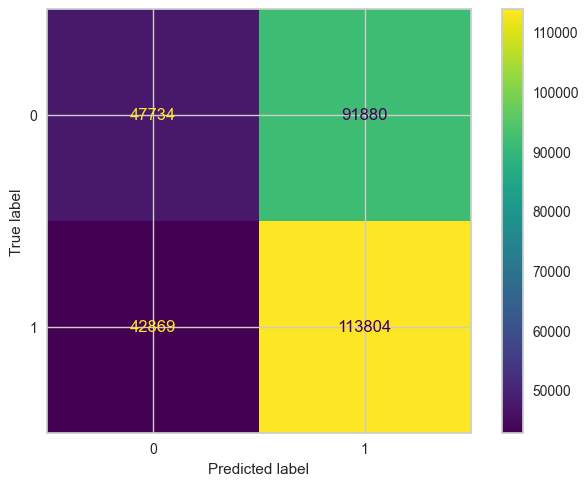

In [74]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

plot_confusion_matrix(dt, X_test, y_test, values_format='')  
plt.show()

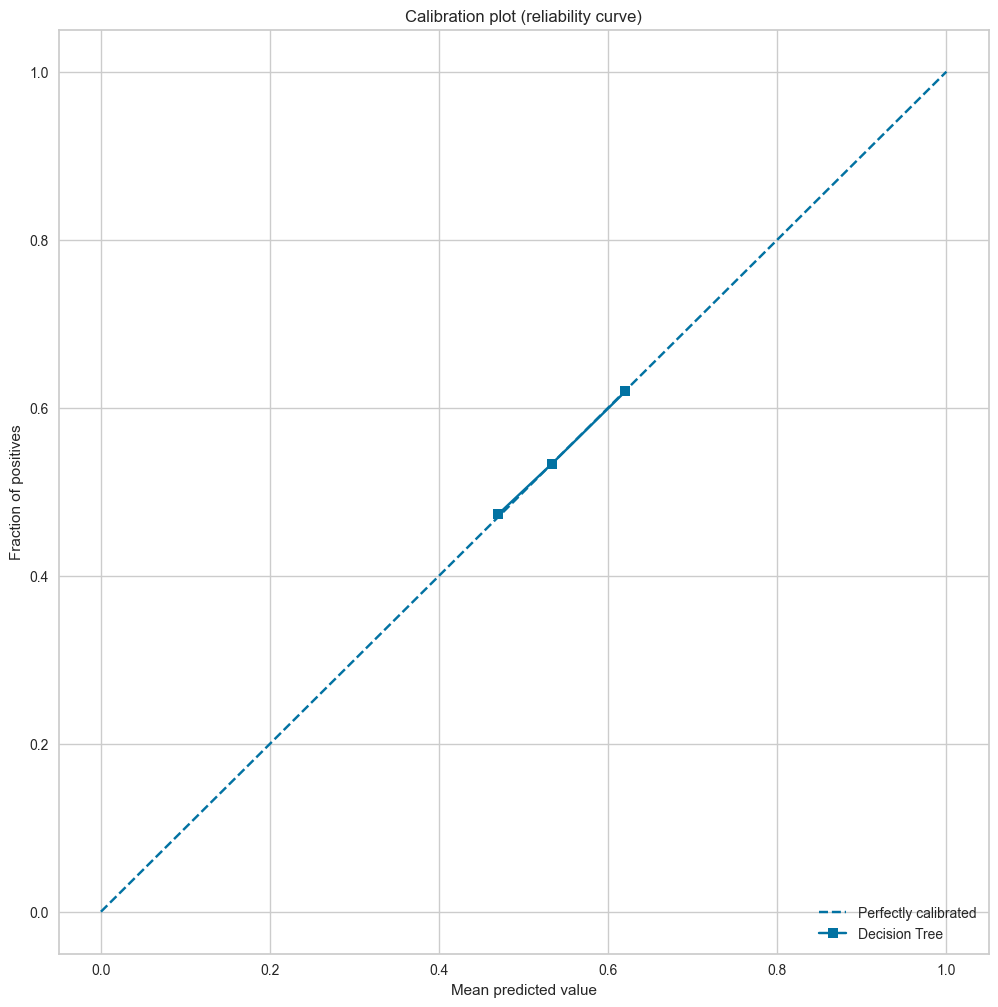

In [75]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot()
ax.plot([0, 1], [0, 1], "b--", label="Perfectly calibrated")
ax.set_ylabel("Fraction of positives")
ax.set_xlabel("Mean predicted value")
ax.set_title('Calibration plot (reliability curve)')

prob_pos_dt = dt.predict_proba(X_test)[:, 1]
fraction_of_positives_dt, mean_predicted_value_dt = calibration_curve(y_test, prob_pos_dt, n_bins=10)
ax.plot(mean_predicted_value_dt, fraction_of_positives_dt, "s-", label="%s" % ('Decision Tree'))

ax.legend(loc="lower right")
plt.show()

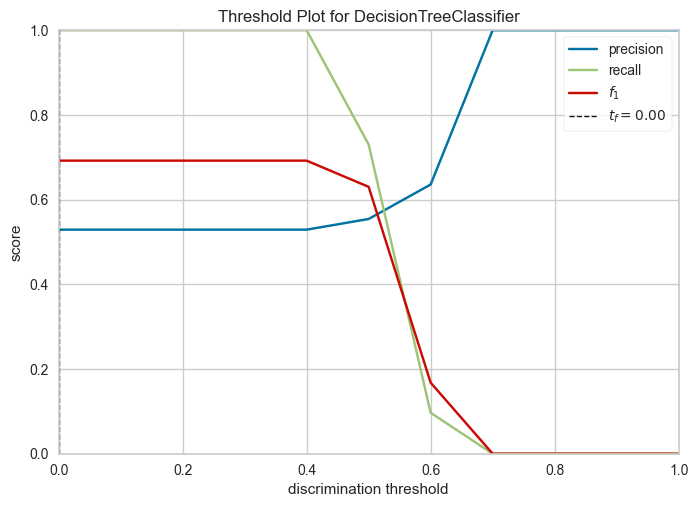

<AxesSubplot:title={'center':'Threshold Plot for DecisionTreeClassifier'}, xlabel='discrimination threshold', ylabel='score'>

In [76]:
from yellowbrick.classifier import DiscriminationThreshold
visualizer = DiscriminationThreshold(dt,
                                     n_trials=1,
                                     cv=0.5,
                                     argmax='fscore',
                                     random_state=0,
                                     is_fitted='auto',
                                     exclude = 'queue_rate')
visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()

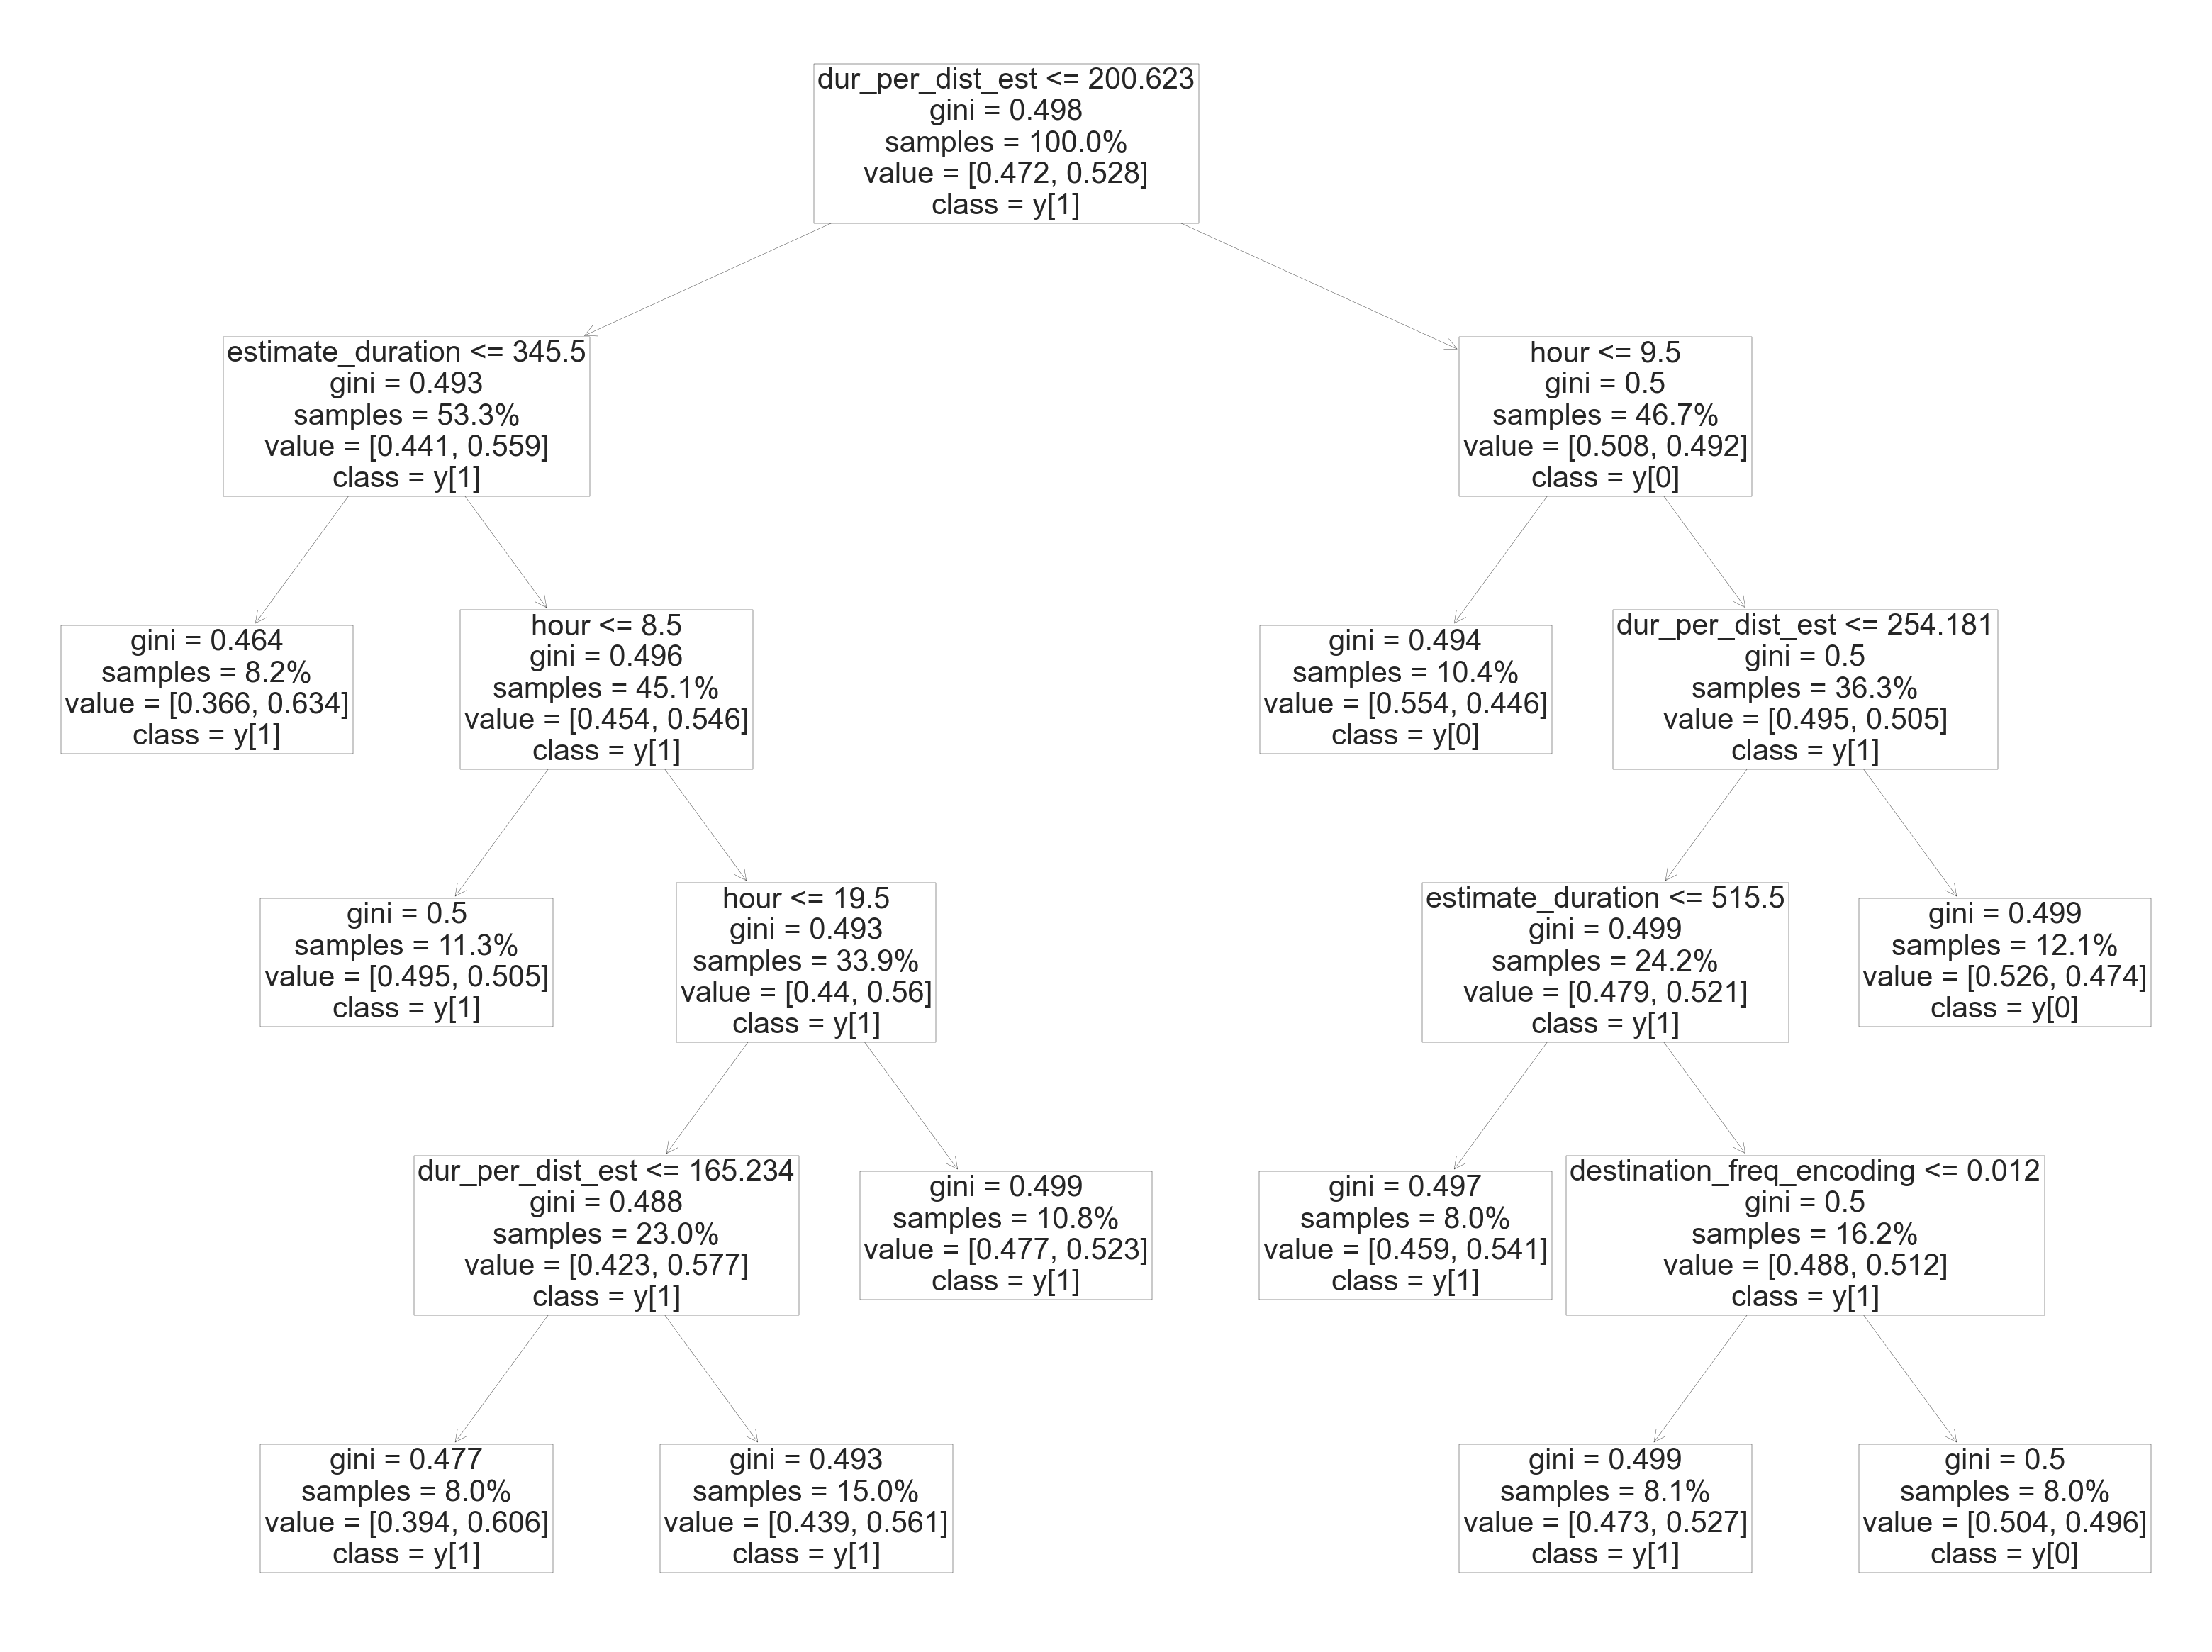

In [77]:
from sklearn import tree

plt.figure(figsize=(40,30))
tree.plot_tree(dt,max_depth=6,feature_names=X_test.columns,class_names=True,proportion=True,fontsize=30)
plt.show()

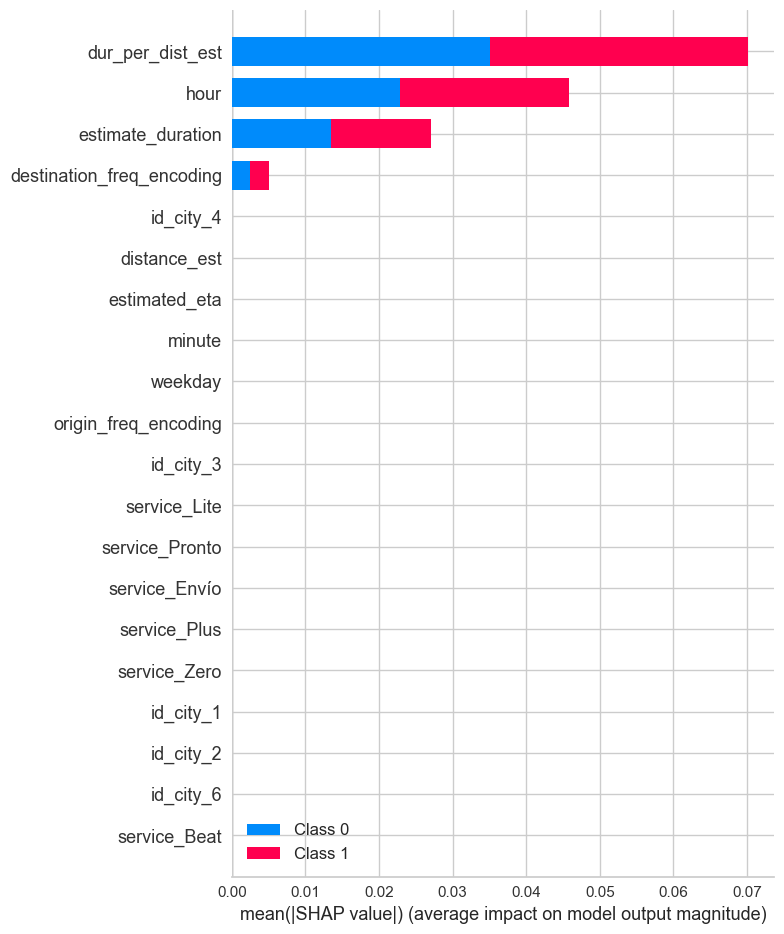

In [78]:
import shap
explainer = shap.TreeExplainer(dt)
shap_values_dt = explainer.shap_values(X_test)
shap.summary_plot(shap_values_dt, X_test, plot_type="bar")

In [79]:
y_pred = (dt.predict_proba(X_test)[:,1] >= 0.47)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.55      0.12      0.20    139614
           1       0.54      0.91      0.68    156673

    accuracy                           0.54    296287
   macro avg       0.54      0.52      0.44    296287
weighted avg       0.54      0.54      0.45    296287



In [80]:
import lightgbm as lgb
lgbm = lgb.LGBMClassifier(n_estimators= 200,
                          learning_rate= 0.07,
                          random_state=23)
lgbm.fit(X_train, y_train)

y_pred=lgbm.predict(X_test)

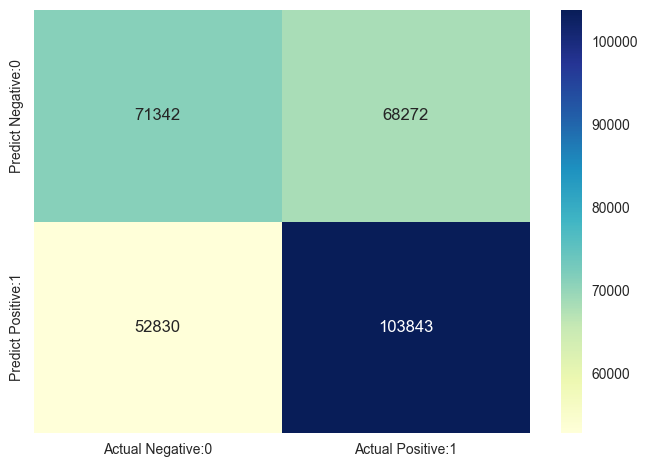

In [81]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Negative:0','Actual Positive:1'], 
                                  index=['Predict Negative:0','Predict Positive:1'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu');

In [82]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.57      0.51      0.54    139614
           1       0.60      0.66      0.63    156673

    accuracy                           0.59    296287
   macro avg       0.59      0.59      0.59    296287
weighted avg       0.59      0.59      0.59    296287



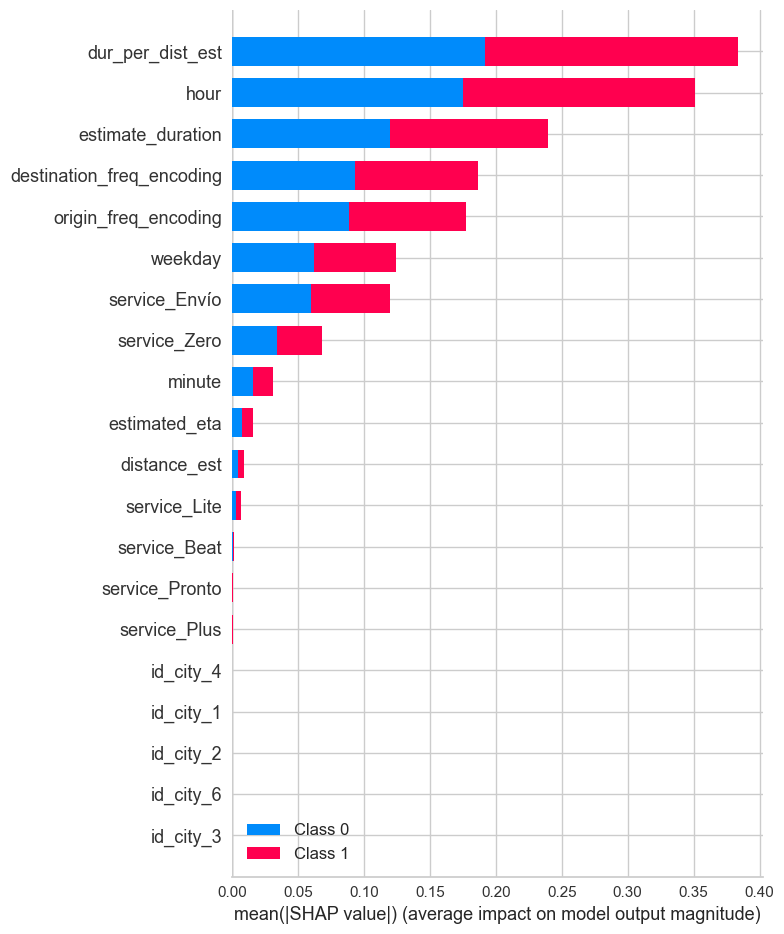

In [83]:
explainer = shap.TreeExplainer(lgbm)
shap_values_lgbm = explainer.shap_values(X_test)
shap.summary_plot(shap_values_lgbm, X_test, plot_type="bar")

In [84]:
lgbm._Booster.dump_model()["tree_info"]

[{'tree_index': 0,
  'num_leaves': 31,
  'num_cat': 0,
  'shrinkage': 1,
  'tree_structure': {'split_index': 0,
   'split_feature': 6,
   'split_gain': 3118.89990234375,
   'threshold': 200.6589825780321,
   'decision_type': '<=',
   'default_left': True,
   'missing_type': 'None',
   'internal_value': 0.111645,
   'internal_weight': 0,
   'internal_count': 691334,
   'left_child': {'split_index': 1,
    'split_feature': 12,
    'split_gain': 2591.9599609375,
    'threshold': 1.0000000180025095e-35,
    'decision_type': '<=',
    'default_left': True,
    'missing_type': 'None',
    'internal_value': 0.120459,
    'internal_weight': 91853.2,
    'internal_count': 368559,
    'left_child': {'split_index': 2,
     'split_feature': 0,
     'split_gain': 1595.3599853515625,
     'threshold': 338.50000000000006,
     'decision_type': '<=',
     'default_left': True,
     'missing_type': 'None',
     'internal_value': 0.118616,
     'internal_weight': 89650.3,
     'internal_count': 359720,


In [85]:
lgbm.booster_.trees_to_dataframe().dropna().sort_values(by='tree_index',ascending=True)

tree_index  node_depth node_index left_child right_child parent_index  \
1               0           2       0-S1       0-S2       0-S29         0-S0   
58              0           5      0-S21      0-L10       0-L22         0-S9   
56              0           4       0-S9       0-L7       0-S21         0-S6   
52              0           7      0-S20      0-L14       0-L21        0-S13   
48              0           8      0-S28       0-L9       0-L29        0-S15   
...           ...         ...        ...        ...         ...          ...   
12141         199           3     199-S2     199-S3      199-L3       199-S1   
12140         199           2     199-S1     199-S2     199-S10       199-S0   
12188         199          11    199-S15    199-L14     199-L16      199-S14   
12159         199          11    199-S17    199-S18     199-S23      199-S16   
12196         199           3    199-S10     199-L2     199-L11       199-S1   

                   split_feature   split_gain     threshold decision_type  \
1                  service_Envío  2591.959961  1.000000e-35            <=   
58              dur_per_dist_est   216.095001  2.669643e+02            <=   
56             estimate_duration   506.175995  6.575000e+02            <=   
52             estimate_duration   222.819000  3.465000e+02            <=   
48                          hour   142.320007  1.650000e+01            <=   
...                          ...          ...           ...           ...   
12141  destination_freq_encoding    11.420800  1.231020e-02            <=   
12140       origin_freq_encoding     5.827120  2.809368e-02            <=   
12188               distance_est     7.670050  3.850500e+00            <=   
12159           dur_per_dist_est     6.781490  1.453348e+02            <=   
12196              estimated_eta     7.030010  1.500000e-01            <=   

      missing_direction missing_type     value     weight   count  
1                  left         None  0.120459  91853.200  368559  
58                 left         None  0.118728   1757.770    7053  
56                 left         None  0.141609   2794.780   11214  
52                 left         None  0.087198   9454.010   37934  
48                 left         None  0.106757  25851.400  103728  
...                 ...          ...       ...        ...     ...  
12141              left         None -0.001575  14631.200   60595  
12140              left         None -0.000923  18704.900   77673  
12188              left         None  0.020875    159.226     662  
12159              left         None -0.005367   1431.270    5942  
12196              left         None  0.001418   4073.670   17078  

[5800 rows x 15 columns]

In [ ]:
coeff = {'id_city':[1,1,1,1,2,2,2,3,3,3,4,4,4,6,6],
         'service':['Beat','Envio','Lite','Zero','Beat','Envio','Lite','Beat','Envio','Lite','Beat','Envio','Lite','Beat','Lite'],
         'duration_coef_local':[119,1,108,840,124,0.1,111,172,0.1,162,90,2.75,84,124,114],
         'duration_coef_scaled_local':[621,644,565,0,660,714,596,613,676,537,798,785,751,436,388]}

In [ ]:
df_coeff = pd.DataFrame(coeff)
df_coeff